In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import sys
sys.path.append("../")

from src.processing import windsat_datacube
from src.model import get_training_batch

In [2]:
folder_path = "../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)
ds

<xarray.Dataset> Size: 3GB
Dimensions:         (day_number: 21, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 121kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 60kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 697MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) int32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [3]:
# Split the dataset in ascending and descending swaths:
ascds = ds.sel(swath_sector = 0)
desds = ds.sel(swath_sector = 1)

In [58]:
# Index only index the pixels with measurements: all freq and pol coincide. (?)
asc_index = np.argwhere(~np.isnan(ascds.tbtoa.sel(polarization = 0, frequency_band = 0).values))
np.random.seed(13)
np.random.shuffle(asc_index)

# des_index = np.argwhere(~np.isnan(desds.tbtoa.sel(polarization = 0, frequency_band = 0).values))

# (day_number, latitude_grid, longitude_grid)

In [59]:
# For now we define the model here, later we will have elsewhere.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization

n_vars = 9

model = Sequential([
    Input((n_vars,)),
    BatchNormalization(),
    Dense(30,activation="relu", name = "hiddenLayer1"),
    Dense(20,activation="relu", name = "hiddenLayer2"),
    Dense(10,activation="relu", name = "hiddenLayer3"),
    Dense(1,activation="relu", name = "outputLayer")

])

model.compile(
    optimizer = "adam",
    loss ="mse",
    metrics = ["mse"]
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_4           │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,177 (4.60 KB)

 Trainable params: 1,159 (4.53 KB)

 Non-trainable params: 18 (72.00 B)

In [60]:
# Now we just read batches of indeces, retrieve the data they represent, 
# and train the model for 1 epoch for each batch.

batch_size = 256

""" Testing with a fraction of the dataset """
asc_index = asc_index[:1000]

n_samples, __ = asc_index.shape

batch_iter = 0

full_history = None
while batch_iter <= n_samples:

    # If there are not enought samples left, break the loop (we could ignore up to batch_size - 1)
    if batch_iter +batch_size > n_samples:
        break
    training_index = asc_index[batch_iter:(batch_iter+batch_size)]
    
    x_train, y_train = get_training_batch(index_list=training_index, ds=ascds)

    batch_history = model.fit(x_train, y_train, epochs=50)

    # Manage the history of each training run
    if full_history is None:
        full_history = batch_history
    else:
        for key in full_history.history.keys():
            full_history.history[key].extend(batch_history.history[key])

    batch_iter += batch_size
    print(batch_iter/n_samples)



Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1000us/step - loss: 74744.0078 - mse: 74744.0078
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74521.5938 - mse: 74521.5938 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74564.0312 - mse: 74564.0312 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74652.3516 - mse: 74652.3516 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74551.7344 - mse: 74551.7344 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72719.9219 - mse: 72719.9219 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 73174.5234 - mse: 73174.5234
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 73239.2656 - mse: 73239.2656 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 71342.4141 - mse: 71342.4141 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70153.4609 - mse: 70153.4609 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 70436.6641 - mse: 70436.6641 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [50]:
# I ABSOLUTELY need to do parallel processing here, 

import concurrent.futures
import pandas as pd
import xarray as xr
from datetime import datetime

def fetch_data(index, ds):
    day, latg, long = index
    subset = ds.sel(day_number=day + 1, latitude_grid=latg, longitude_grid=long)

    time_18ghz, time_37ghz = subset.time.values.flatten()

    tbtoa_18ghz_V, tbtoa_37ghz_V, tbtoa_18ghz_H, tbtoa_37ghz_H = subset.tbtoa.values.flatten()

    xv = {
        "day_number": day + 1, # Possibly normalise this to be 0-1 instead of 0-366
        "lat": float(subset.lat.values),
        "lon": float(subset.lon.values), # Periodic transformation (sin or cos, opposite ends should be close)
        # Normalized time (seconds since midnight UTC to fraction of the day)
        "time_18ghz" : time_18ghz / (24*60*60),
        "time_37ghz" : time_37ghz / (24*60*60),
        # Tbs for chanels and emmisivities
        "tbtoa_18ghz_V": tbtoa_18ghz_V,
        "tbtoa_37ghz_V": tbtoa_37ghz_V,
        "tbtoa_18ghz_H": tbtoa_18ghz_H,
        "tbtoa_37ghz_H": tbtoa_37ghz_H,
        "surtep_ERA5": float(subset.surtep_ERA5.values),
    }

    return xv

def get_training_batch(index_list, ds):
    global_bias = (datetime(2017, 1, 1, 0, 0, 0) - datetime(2000, 1, 1, 0, 0)).total_seconds()

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(fetch_data, index, ds) for index in index_list]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]

    batch_df = pd.DataFrame(results)

    #NOTE Error by 1, we need to substract 1 day, since the origin is 2017-01-01. not 2017-0-0.
    #NOTE: All times in seconds since midnight UTC
    batch_df["time_18ghz"] += - global_bias - (batch_df["day_number"] - 1)* 24 * 60 * 60
    batch_df["time_37ghz"] += - global_bias - (batch_df["day_number"] - 1)* 24 * 60 * 60

    # Normalise the values to be between 0 and 1 (0.5 = mid day) 
    batch_df["time_18ghz"] = batch_df["time_18ghz"] / (24*60*60)
    batch_df["time_37ghz"] = batch_df["time_37ghz"] / (24*60*60)

    # Loop longitude so 0 and 360 are close.
    batch_df["lon"] = batch_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))


    y_vars = ["surtep_ERA5"]
    x_train = batch_df[[col for col in batch_df.columns if col not in y_vars]]
    y_train = batch_df[y_vars]
    
    return x_train, y_train

AttributeError: 'NoneType' object has no attribute 'history'

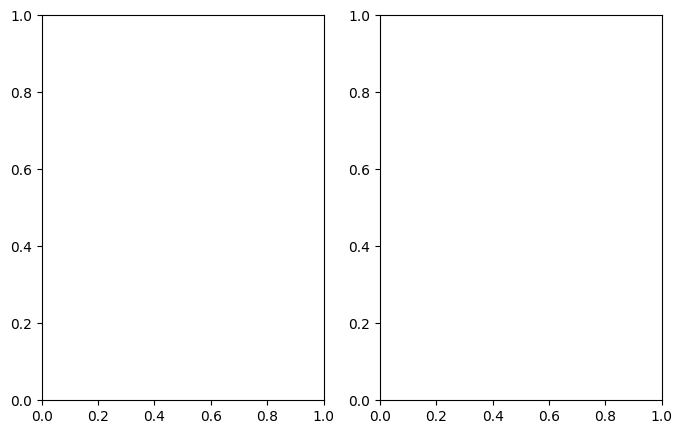

In [51]:
# Plot the training history:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize = (8,5))
ax[0].plot(full_history.history["loss"])
ax[1].plot(full_history.history["loss"][-100:])

In [42]:
x_train["time_37ghz"] / (24*60*60)

0      0.435038
1      0.060780
2      0.864463
3      0.863924
4      0.653369
         ...   
251    0.098924
252    0.464154
253    0.711413
254    0.689277
255    0.958269
Name: time_37ghz, Length: 256, dtype: float64

In [43]:
x_train["lon"]

0      110.625
1      247.375
2      313.125
3      336.875
4      116.875
        ...   
251    238.375
252    118.375
253     84.125
254     52.125
255    310.125
Name: lon, Length: 256, dtype: float64